In [1]:
from Imports import *
from Plotting import *
from Helper import *
from Preprocessing import *
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(device)

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

cuda
<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


[ 2.36100139e-01-4.90112988e-02j  5.06676991e-04-1.08357083e-02j
  1.92158876e-01-3.98896677e-02j -8.10518541e-03+1.18263647e-04j
  2.17109053e-01-1.04923984e-01j  1.60129659e-01-3.22556813e-02j
  1.76702274e-01-8.53962854e-02j -3.13908884e-02-1.17958219e-01j
  4.29636255e-03+2.00897623e-04j  2.36100139e-01-4.90112988e-02j
 -4.68915818e-05-3.21370916e-03j  1.92158876e-01-3.98896677e-02j
  1.27893901e-02+6.34914718e-02j  2.17109053e-01-1.04923984e-01j
  4.67704798e-02-1.24464994e-02j  1.76702274e-01-8.53962854e-02j
  1.78783575e-01-3.71131302e-02j  3.83674165e-04-8.20519071e-03j
  1.45509659e-01-3.02059008e-02j -6.13753989e-03+8.95535158e-05j
  1.64402836e-01-7.94522402e-02j  1.21255976e-01-2.44251699e-02j
  1.33805360e-01-6.46651596e-02j -2.37703174e-02-8.93222352e-02j
  3.25336130e-03+1.52126955e-04j  1.78783575e-01-3.71131302e-02j
 -3.55080038e-05-2.43353695e-03j  1.45509659e-01-3.02059008e-02j
  9.68458933e-03+4.80780416e-02j  1.64402836e-01-7.94522402e-02j
  3.54163009e-02-9.424940

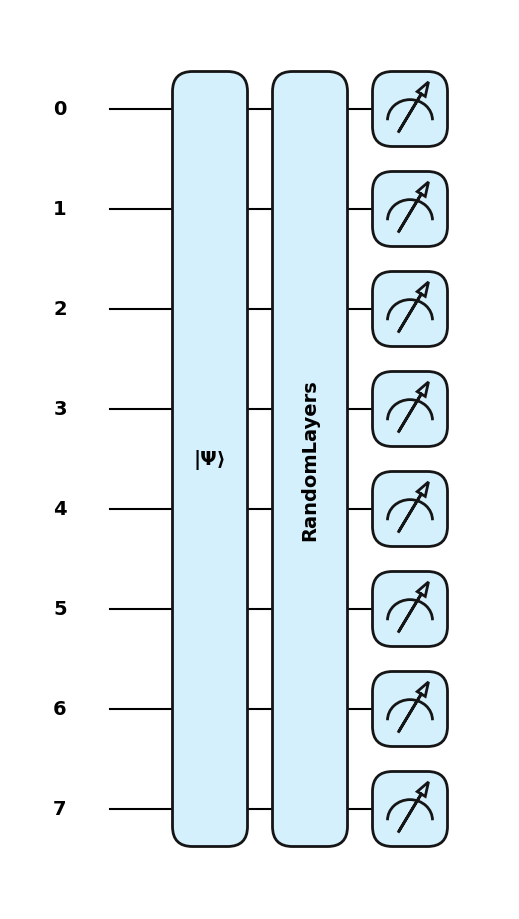

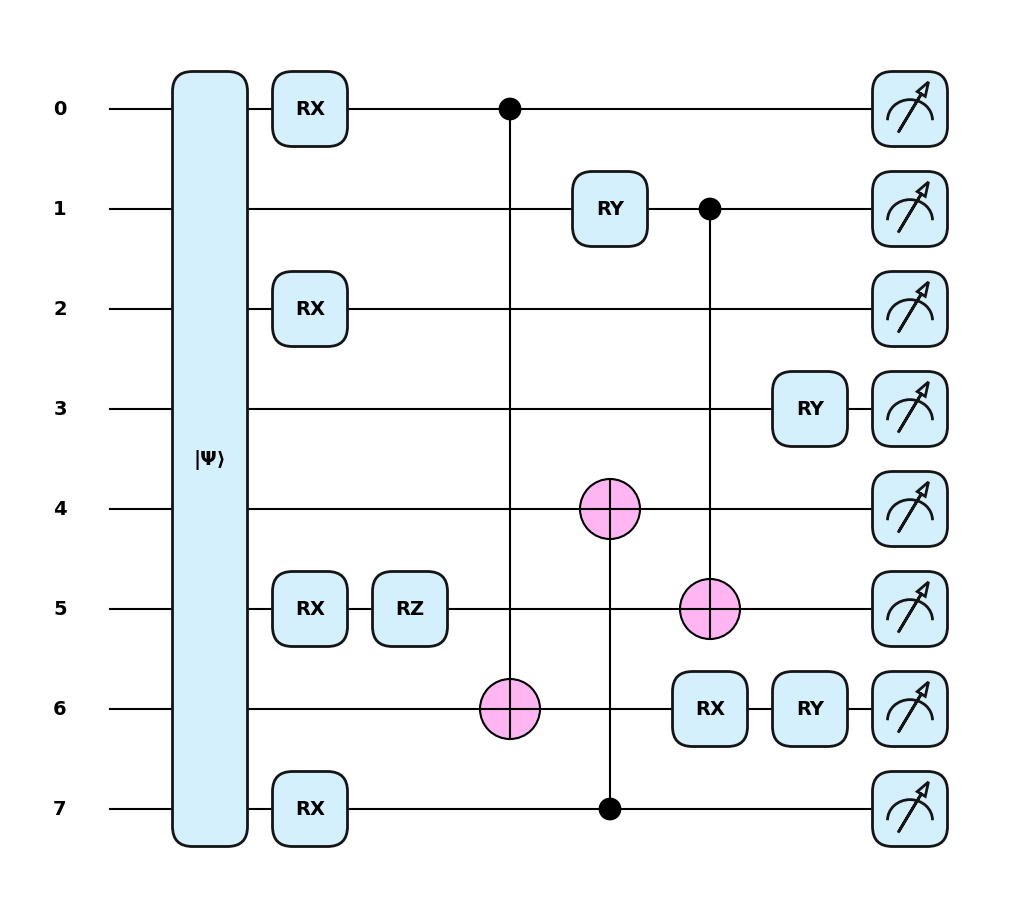

In [3]:
dev = qml.device("default.qubit", wires=8)
n_layers = 3

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 3))

@qml.qnode(dev)
def quantum_feature_embedding(f, phi, interface="torch", diff_method="backprop", cachesize=1000000):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True, pad_with=0.)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(8)), seed=40 )

    # Measurement producing classical output values
    return qml.state()

state = quantum_feature_embedding(f=[1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4], phi=rand_params)
print(state)

def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    outputs = []
    for x in x_batch:
        result = quantum_feature_embedding(x, phi)
        result_tensor = result.real.to(device)
        outputs.append(result_tensor)

    return torch.stack(outputs)

sample = torch.randn(16, 9).to(device)  # Example batch
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)

output = quantum_feature_embedding_batch(sample, phi_tensor)
print(output.shape)

class quantum_feature_embedding_batch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.phi = nn.Parameter(torch.tensor(np.random.uniform(high=2 * np.pi, size=(n_layers, 3)), dtype=torch.float32))
    
    def forward(self, x_batch):
        phi = self.phi
        outputs = []
        for x in x_batch:
            result = quantum_feature_embedding(x, phi)
            result_tensor = result.real.to(device)
            outputs.append(result_tensor)
    
        return torch.stack(outputs)

qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding)(f=[1/4]*9, phi=rand_params)
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*9, phi=rand_params)

In [4]:
# Generator with Quantum Layer
class Generator(nn.Module):
    def __init__(self, latent_dim=9):
        super().__init__()

        self.noise = GaussianNoise(sigma=0.1)

        self.eps_relu = eps_relu(epsilon = 1e-3)
        
        self.feature_gen = quantum_feature_embedding_batch()

        self.image_gen1 = nn.Sequential(
            self.noise,
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid(),
            # self.eps_relu
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat).float()
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 128

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([8726, 16, 16])
dR Mean: torch.Size([8726])
dR STD: torch.Size([8726])
Pixel Mean: torch.Size([8726])
Pixel STD: torch.Size([8726])
ΔR min: 0.0
ΔR max: 2.0372369289398193
ΔR mean min: 0.00444405060261488
ΔR mean max: 0.014574162662029266
ΔR std min: 0.022066839039325714
ΔR std max: 0.1351994276046753
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0029388333205133677
Pixel mean max: 0.004459979943931103
Pixel std min: 0.011304350569844246
Pixel std max: 0.06250042468309402


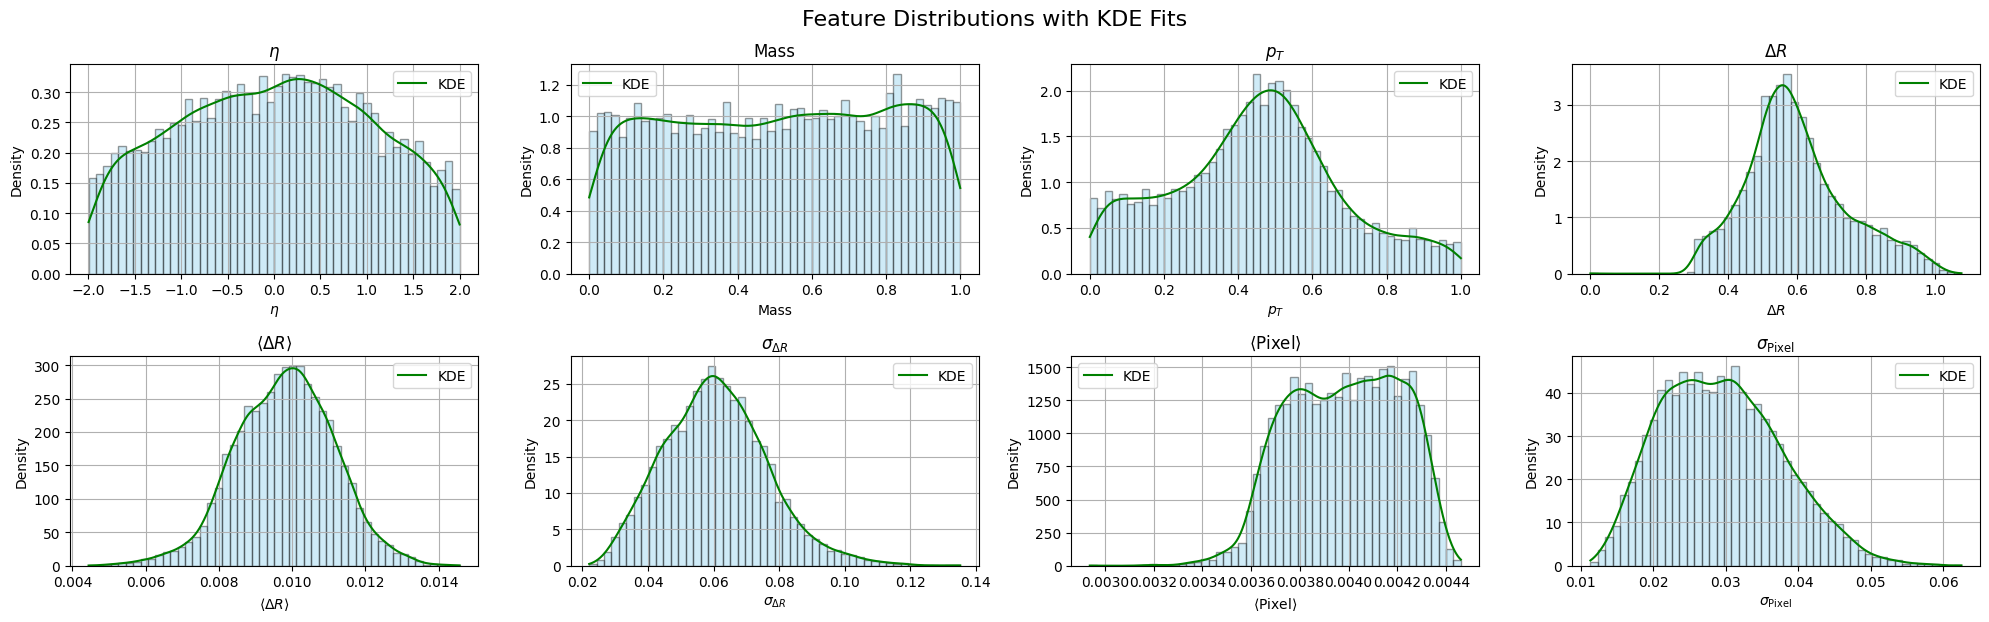

Number of samples: 8726
Image shape: torch.Size([8726, 16, 16])
Feature shape: torch.Size([8726, 9])


In [5]:
batch_size = 64
n_events = int(.01 * jet_mass_data['image'].shape[0])

latent_dim = 256
lr = 1e-3
n_epochs = 300
num = 4

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [6]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=n_epochs, eta_min=1e-4)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=n_epochs, eta_min=1e-4)

g_losses = []
d_losses = []

# Tracking buffers
stats_dict = {
    'fake_dR_mean': [],
    'fake_dR_std': [],
    'fake_pixel_mean': [],
    'fake_pixel_std': [],
    'real_dR_mean': [],
    'real_dR_std': [],
    'real_pixel_mean': [],
    'real_pixel_std': []
}

dists = compute_distance_map(16,16).to(device)

In [7]:
## Load a previous model
# Replace with the desired filename
load = True

if load:
    load_path = "models/3x3_RandLayer_QGAN_0718_1825.pt"
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    
    # Optionally restore tracking data
    g_losses = checkpoint["g_losses"]
    d_losses = checkpoint["d_losses"]
    
    # stats_dict = checkpoint["stats_dict"]
    
    print(f"Loaded model from {load_path}")

Loaded model from models/3x3_RandLayer_QGAN_0718_1825.pt


In [8]:
if False:
    for epoch in range(n_epochs):
        for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
            
            # All real data are normalized in the dataloader
            real_feat = real_features.to(device)
            real_flipped_feat = flipped_features.to(device)
            real_img = real_image.unsqueeze(1).to(device)
            real_flipped_img = flipped_image.unsqueeze(1).to(device)
    
            # print(f"Real: {real_img.shape}")
    
            # Codings should be label, eta, pT, mass that get passed directly to the discriminator
            # Other values get passed to the generator, then the output image passed to the discriminator
            
            # Discriminator training
            if i % 3 == 0:
                optimizer_D.zero_grad()
                discriminator.train()
                # Generate fake samples
                # Should be very easy to modify which values are passed as codings
                z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                      sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                      dim=1).to(device)
    
                # Discriminator gets z_codings + generated_features
                fake_img = generator(z_codings)
                # print(f"Fake: {fake_img.shape}")
    
                # Generate eta-flipped data
                flipped_z_codings = z_codings.clone()
                flipped_z_codings[:, 1] *= -1
                
                fake_flipped_img = generator(flipped_z_codings)
    
                # Get predictions and labels
                real_disc_codings = real_feat[:,:num]
                real_flipped_disc_codings = real_flipped_feat[:,:num]
                fake_disc_codings = z_codings[:,:num]
                fake_flipped_disc_codings = flipped_z_codings[:,:num]
    
                real_pred = discriminator(real_img, real_disc_codings)
                real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
                fake_pred = discriminator(fake_img, fake_disc_codings)
                fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)
    
                preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)
    
                ones = torch.ones(2*len(fake_pred))
                zeros = torch.zeros(2*len(real_pred))
                labels = (torch.cat([ones, zeros], dim=0)).to(device)
    
                # Discriminator loss is just its ability to distinguish
                d_loss = torch.nn.BCELoss()(preds, labels)
    
                d_loss.backward()
                optimizer_D.step()
    
            # Generator Training
            if i % 1 == 0:
                optimizer_G.zero_grad()
                # generator.train()
                
                # Generate fake data
                # Should be very easy to modify which values are passed as codings
                z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                      sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                      dim=1).to(device)
    
                # Discriminator gets z_codings + generated_features
                fake_img = generator(z_codings)
    
                # Generate eta-flipped data
                flipped_z_codings = z_codings.clone()
                flipped_z_codings[:, 1] *= -1
    
                fake_flipped_img = generator(flipped_z_codings)
    
                # Get predictions and labels
                fake_disc_codings = z_codings[:,:num]
                fake_flipped_disc_codings = flipped_z_codings[:,:num]
    
                # Fooled discriminator loss
                d_out = discriminator(fake_img, fake_disc_codings)
                d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
                real_pred = discriminator(real_img, real_disc_codings)
                real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
    
                target = torch.ones_like(d_out)
                bce = nn.BCELoss()
                validity_loss = bce(d_out, target) + bce(d_out_flip, target)
    
                ## Stat loss
                # Compute fake statistics
                fake_stats = compute_fake_statistics(fake_img, dists)
    
                fake_dR_mean = fake_stats['fake_dR_mean']
                fake_dR_std = fake_stats['fake_dR_std']
                fake_pixel_mean = fake_stats['fake_pixel_mean']
                fake_pixel_std = fake_stats['fake_pixel_std']
    
                # Get real stats from z_codings (features 5–8)
                real_dR_mean = z_codings[:,5]
                real_dR_std = z_codings[:,6]
                real_pixel_mean = z_codings[:,7]
                real_pixel_std = z_codings[:,8]
    
                real_stats = {
                    'real_dR_mean': real_dR_mean,
                    'real_dR_std': real_dR_std,
                    'real_pixel_mean': real_pixel_mean,
                    'real_pixel_std': real_pixel_std
                }
    
                if n_epochs - epoch <= 10:
                    # Track the last statistics
                    track_statistics(stats_dict, fake_stats, real_stats)
    
                # Statistical MSE loss
                # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
                # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
                # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
                # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
                
                # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss
    
                # print(dR_mean_loss)
                # print(dR_std_loss)
                # print(3*pixel_mean_loss)
                # print(2*pixel_std_loss)
    
                # Statistical KL Divergence loss
                kl_total = 0
                kl1 = kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / 0.03
                # print(f"KL(real_dR_mean, fake_dR_mean) = {kl1.item()}")
                
                kl2 = kde_kl_divergence_torch(real_dR_std, fake_dR_std) / 0.003
                # print(f"KL(real_dR_std, fake_dR_std) = {kl2.item()}")
                
                kl3 = kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / 0.0005  # Avoid division by zero
                # print(f"KL(real_pixel_mean, fake_pixel_mean) = {kl3.item()}")
                
                kl4 = kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / 0.0001
                # print(f"KL(real_pixel_std, fake_pixel_std) = {kl4.item()}")
                
                kl_total = kl1 + kl2 + kl3 + kl4
    
    
                stat_loss = kl_total
    
                # Number non-zero loss
                fake_nnz = soft_count_nonzero(fake_img, threshold=3e-5, sharpness=10000.0)
                real_nnz = soft_count_nonzero(real_img, threshold=3e-5, sharpness=10000.0)
                nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)
    
                
                # Total generator loss is the average of the discriminator's predictions of the original and flipped data
                # + the difference between input and output dR and pixel statistics
    
                alpha = .3
                beta = .000005
                chi = .05
    
                g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)
    
                g_loss.backward()
                optimizer_G.step()
    
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
    
        print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[-1]:.4f}] [G loss: {g_losses[-1]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 
    
        plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)
    
    plot_metrics(g_losses, d_losses)
    
    plot_tracked_statistics(stats_dict)

In [9]:
## Save Model
# Create output directory if it doesn't exist
save = False

if save:
    os.makedirs("models", exist_ok=True)
    
    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/3x3_RandLayer_QGAN_{timestamp}.pt"
    torch.save({
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_losses": g_losses,
        "d_losses": d_losses,
        "stats_dict": stats_dict
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)

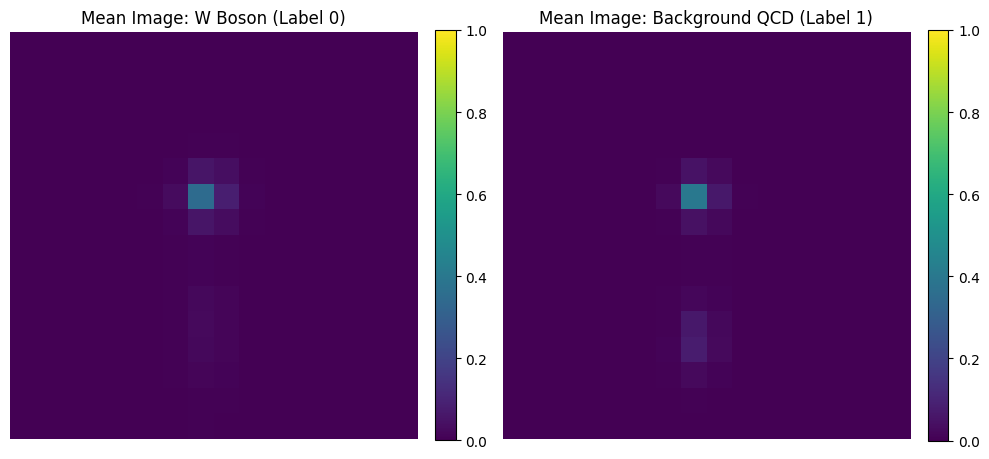

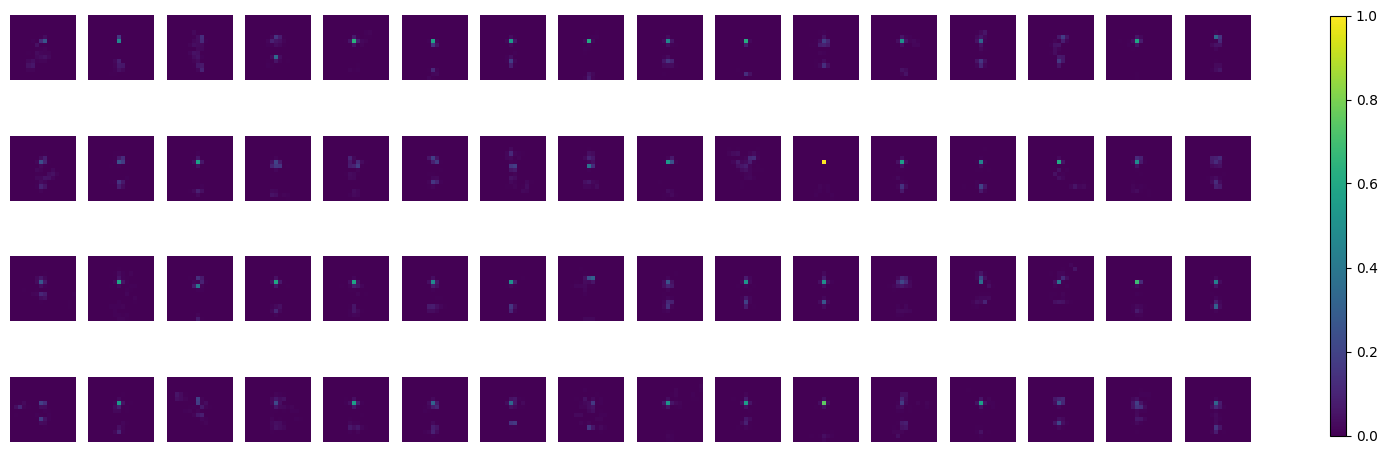

In [10]:
plot_real_samples(dataset)

Sample feature coding: [1.         1.8649058  0.20045261 0.4570208  0.8814426  0.01157506
 0.05156153 0.00425407 0.03767259]


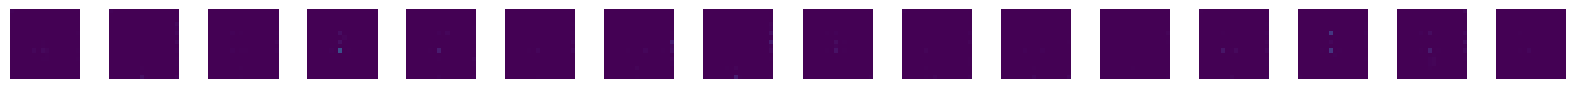

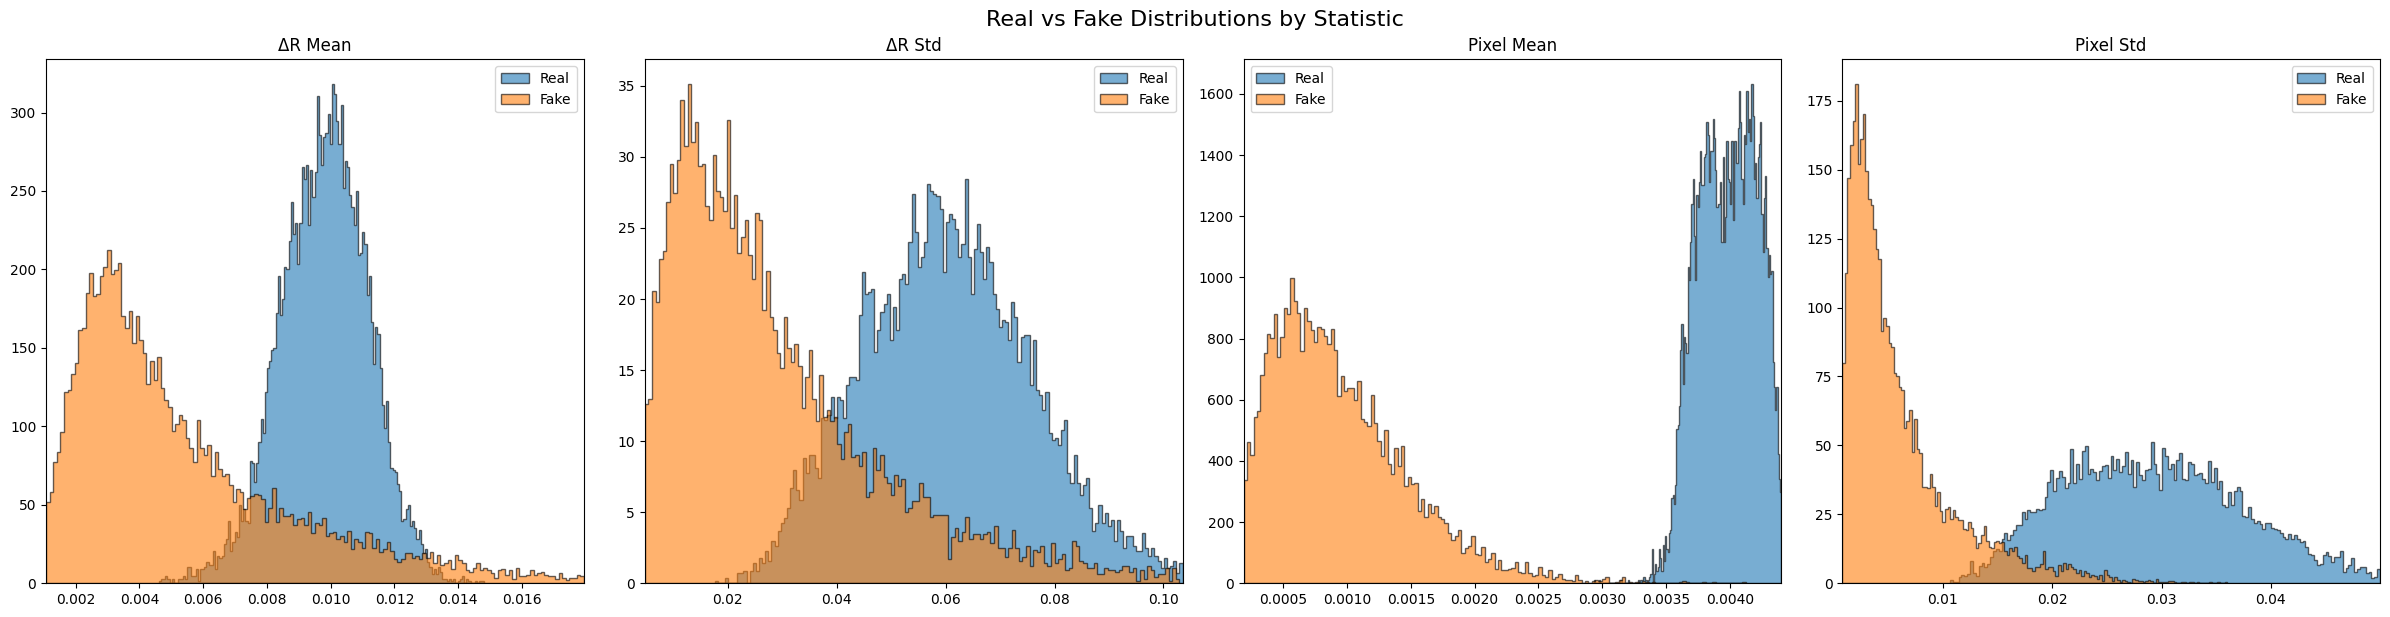

Discriminator output (wrong label): [0.48902434 0.48876777 0.49850607 ... 0.51387495 0.48494154 0.48866028]
Discriminator output (correct label): [0.5116875  0.5125966  0.5140985  ... 0.51389694 0.4909305  0.48568013]
Real labels: [1. 1. 1. ... 0. 0. 0.]
Swapped labels: [0. 0. 0. ... 0. 0. 0.]
Relative change (%): [-4.4291019e+00 -4.6486497e+00 -3.0329704e+00 ... -4.2796135e-03
 -1.2199163e+00  6.1360598e-01]


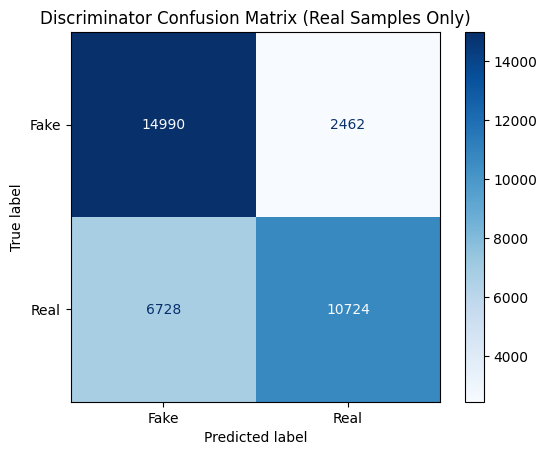

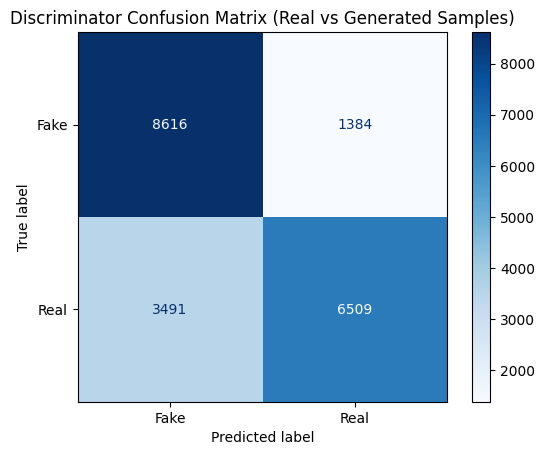

In [11]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=10000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True